### Preface: this study is stage 2 in the development of a project on cryptocurrencies and step 2 in clustering.

import required libs

In [32]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from tqdm.autonotebook import tqdm
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
from sklearn.decomposition import PCA

In [33]:
def get_info(ticker_obj):
    info_keys = ['shortName']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

Upload the data using the functions from the first stage

In [34]:
interesting_tickers = ['BTC-USD','ETH-USD', 'BNB-USD', 'ADA-USD', 'DOGE-USD', 'SHIB-USD', 'LTC-USD', 'ETC-USD', 
           'BCH-USD', 'VET-USD', 'FIL-USD', 'SNX-USD', 'KAVA-USD', 'TWT-USD', 'KSM-USD', 'YFI-USD',
          'UTK-USD', 'RPL-USD', 'SOL-USD', '1INCH-USD', 'THETA-USD', 'OCEAN-USD', 'CHR-USD', 'WRX-USD',
          'DENT-USD', 'DNT-USD', 'CRV-USD', 'DOT-USD', 'KEY-USD', 'BEAM-USD', 'MATIC-USD', 'HEX-USD',
           'AAVE-USD', 'EGLD-USD', 'BTT-USD', 'CAKE-USD', 'HNT-USD', 'DASH-USD', 'ZIL-USD','XDC-USD',
           'KSM-USD','CEL-USD', 'QTUM-USD', 'GLM-USD', 'WAXP-USD', 'NFLX-USD', 'QNT-USD', 'AAPL-USD',
          'NVDA-USD', 'GOOGL-USD']
load = False

if load:
    full_ticker_data = []
    for ticker in tqdm(interesting_tickers):
        try:
            ticker_obj = yf.Ticker(ticker)
            close_price = ticker_obj.history(period='1y', interval='1d')['Close'].to_dict()
            info = get_info(ticker_obj)
            info.update(close_price)
            full_ticker_data.append(info)
        except Exception as e:
            print(e)
            continue
        
    full_ticker_df_0 = pd.DataFrame(full_ticker_data)
    full_ticker_df = pd.DataFrame(full_ticker_df_0.iloc[:,1:].pct_change(axis='columns'))
    full_ticker_df.insert(0, "shortName", full_ticker_df_0.shortName)
    full_ticker_df.to_csv("full_ticker_df_month_01_2022.csv")

else: 
    full_ticker_df = pd.read_csv("full_ticker_df_month_01_2022.csv", index_col=0)
    datetime_columns = pd.to_datetime(full_ticker_df.columns[5:])
    full_ticker_df.columns = list(full_ticker_df.columns[:5]) + list(datetime_columns)

Prepare the data using the code from the first step

In [37]:
full_ticker_df = full_ticker_df.iloc[:, :-1]
prices = full_ticker_df.iloc[:, 5:].T
prices = prices.fillna(method='backfill')
prices = prices.fillna(method='ffill')
full_ticker_df = full_ticker_df.iloc[:, :5].join(prices.T)

In [38]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(full_ticker_df.iloc[:, 5:].T).T

# Feature extractors

### Prepare this data for working with fiches, so let's create a frame of index data for each day, only now with already scaled values.

In [39]:
tickers_scaled_2_df = pd.DataFrame(tickers_scaled, index=full_ticker_df.shortName, columns=full_ticker_df.iloc[:,:-5].columns).drop(columns='shortName')
tickers_scaled_2_df.head()

,2021-10-06 00:00:00,2021-10-07 00:00:00,2021-10-08 00:00:00,2021-10-09 00:00:00,2021-10-10 00:00:00,2021-10-11 00:00:00,2021-10-12 00:00:00,2021-10-13 00:00:00,2021-10-14 00:00:00,2021-10-15 00:00:00,...,2022-09-21 00:00:00,2022-09-22 00:00:00,2022-09-23 00:00:00,2022-09-24 00:00:00,2022-09-25 00:00:00,2022-09-26 00:00:00,2022-09-27 00:00:00,2022-09-28 00:00:00,2022-09-29 00:00:00,2022-09-30 00:00:00
shortName,,,,,,,,,,,,,,,,,,,,,
Bitcoin USD,1.517292,-0.672519,0.776083,0.023531,2.250562,-0.270017,0.382831,0.289349,1.121614,0.854273,...,0.720345,-0.106906,0.549505,0.285149,-0.147510,-0.116490,-0.342859,0.956758,1.130394,-0.189848
Ethereum USD,0.826881,-0.297973,0.773816,1.165445,0.495900,-0.150220,0.137170,-0.539261,0.815581,1.660840,...,0.756300,-0.049388,0.162254,0.008781,-0.091352,-0.239498,-0.574087,0.877053,0.699190,-0.115637
BNB USD,0.551642,1.941979,1.600231,0.078070,0.100591,-0.440688,0.288478,0.816675,0.171688,0.700624,...,0.186124,-0.329262,0.912804,0.194399,0.044328,-0.115282,0.152139,0.247319,0.856257,-0.184908
Cardano USD,-0.152609,-0.440983,0.743761,-0.105442,0.486759,-0.272011,-0.125704,-0.202993,-0.077850,0.776009,...,0.095339,-0.153648,-0.143740,0.110421,-0.106138,-0.124846,-0.437633,0.477106,0.440547,-0.141663
Dogecoin USD,0.202115,-0.413289,0.622884,0.024845,0.183881,0.357940,0.103307,0.857125,-0.072266,0.741623,...,0.030066,-0.109452,0.055839,0.086512,0.362391,-0.288962,-0.400220,0.428893,1.938869,-0.329017


### Set the feature extractors with different numbers of metrics, then look at the result and choose the one that more accurately distributes the assets into clusters

In [40]:
data=[]
for i in range(50):
    for j in range(360):
        data.append(tickers_scaled_2_df.iloc[i,j])
data = pd.DataFrame(data)
data['index_coin'] = np.repeat(range(50), 360)
#data
extraction_settings_Comprehensive = ComprehensiveFCParameters()
extraction_settings_Minimal = MinimalFCParameters()
extraction_settings_Efficient = EfficientFCParameters()


X_Comprehensive = extract_features(data, column_id='index_coin', impute_function=impute,
                    default_fc_parameters=extraction_settings_Comprehensive)
X_Minimal = extract_features(data, column_id='index_coin', impute_function=impute,
                    default_fc_parameters=extraction_settings_Minimal
X_Efficient = extract_features(data, column_id='index_coin', impute_function=impute,
                    default_fc_parameters=extraction_settings_Efficient)


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


### Let's remove those indexes that have missing values (i.e. these indexes are not needed and will only complicate and spoil the cluster distribution)!

In [41]:
X_Comprehensive = X_Comprehensive.dropna(axis=1)
X_Minimal = X_Minimal.dropna(axis=1)
X_Efficient = X_Efficient.dropna(axis=1)

## Visualise for each set of features the distribution of assets into clusters. Again, of course, let's look at the silhouette metric (as it gives a more accurate answer to the question about the number of clusters compared to the elbow method)

  0%|          | 0/28 [00:00<?, ?it/s]

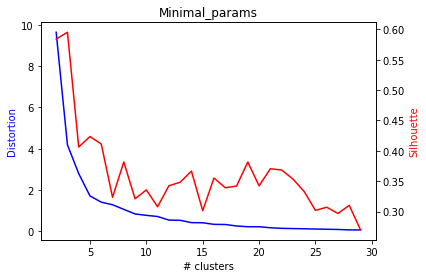

  0%|          | 0/28 [00:00<?, ?it/s]

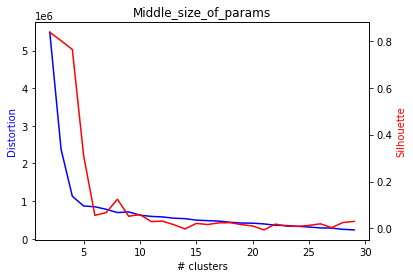

  0%|          | 0/28 [00:00<?, ?it/s]

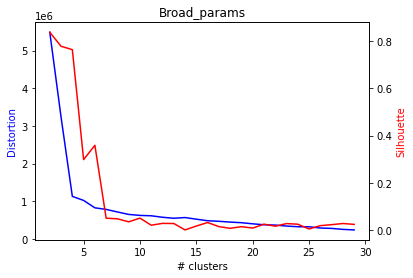

In [42]:
distortions = []
silhouette = []
K = range(2,30)
for feature_matrix, type_ in zip([X_Minimal, X_Efficient, X_Comprehensive], ['Minimal_params', 'Middle_size_of_params', 'Broad_params']):
    distortions = []
    silhouette = []
    for k in tqdm(K):
        kmeanModel = TimeSeriesKMeans(n_clusters=k)
        kmeanModel.fit(feature_matrix)
        distortions.append(kmeanModel.inertia_)
        silhouette.append(silhouette_score(feature_matrix, kmeanModel.labels_, metric="euclidean"))
        
    fig, ax1 = plt.subplots()
       
    plt.title(type_)
    ax2 = ax1.twinx()
    ax1.plot(K, distortions, 'b-')
    ax2.plot(K, silhouette, 'r-')
        
    ax1.set_xlabel('# clusters')
    ax1.set_ylabel('Distortion', color='b')
    ax2.set_ylabel('Silhouette', color='r')
      
    plt.show()

Prepare data for visualisation by predicting clusters for assets using each set and distributing them to each individual frame

In [43]:
n_clusters = [3,6,5]

ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters[0], metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(X_Minimal)
full_ticker_df_1 = full_ticker_df
full_ticker_df_1['cluster_min_feature'] = ts_kmeans.predict(X_Minimal)

ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters[1], metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(X_Efficient)
full_ticker_df_2 = full_ticker_df.drop(columns='cluster_min_feature')
full_ticker_df_2['cluster_mid_feature'] = ts_kmeans.predict(X_Efficient)

ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters[2], metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(X_Comprehensive)
full_ticker_df_3 = full_ticker_df.drop(columns=['cluster_min_feature'])
full_ticker_df_3['cluster_broad_feature'] = ts_kmeans.predict(X_Comprehensive)

In [44]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

Visualise the final cluster distribution for each feature type

                          Cluster name: cluster_min_feature
                          Cluster number: 0


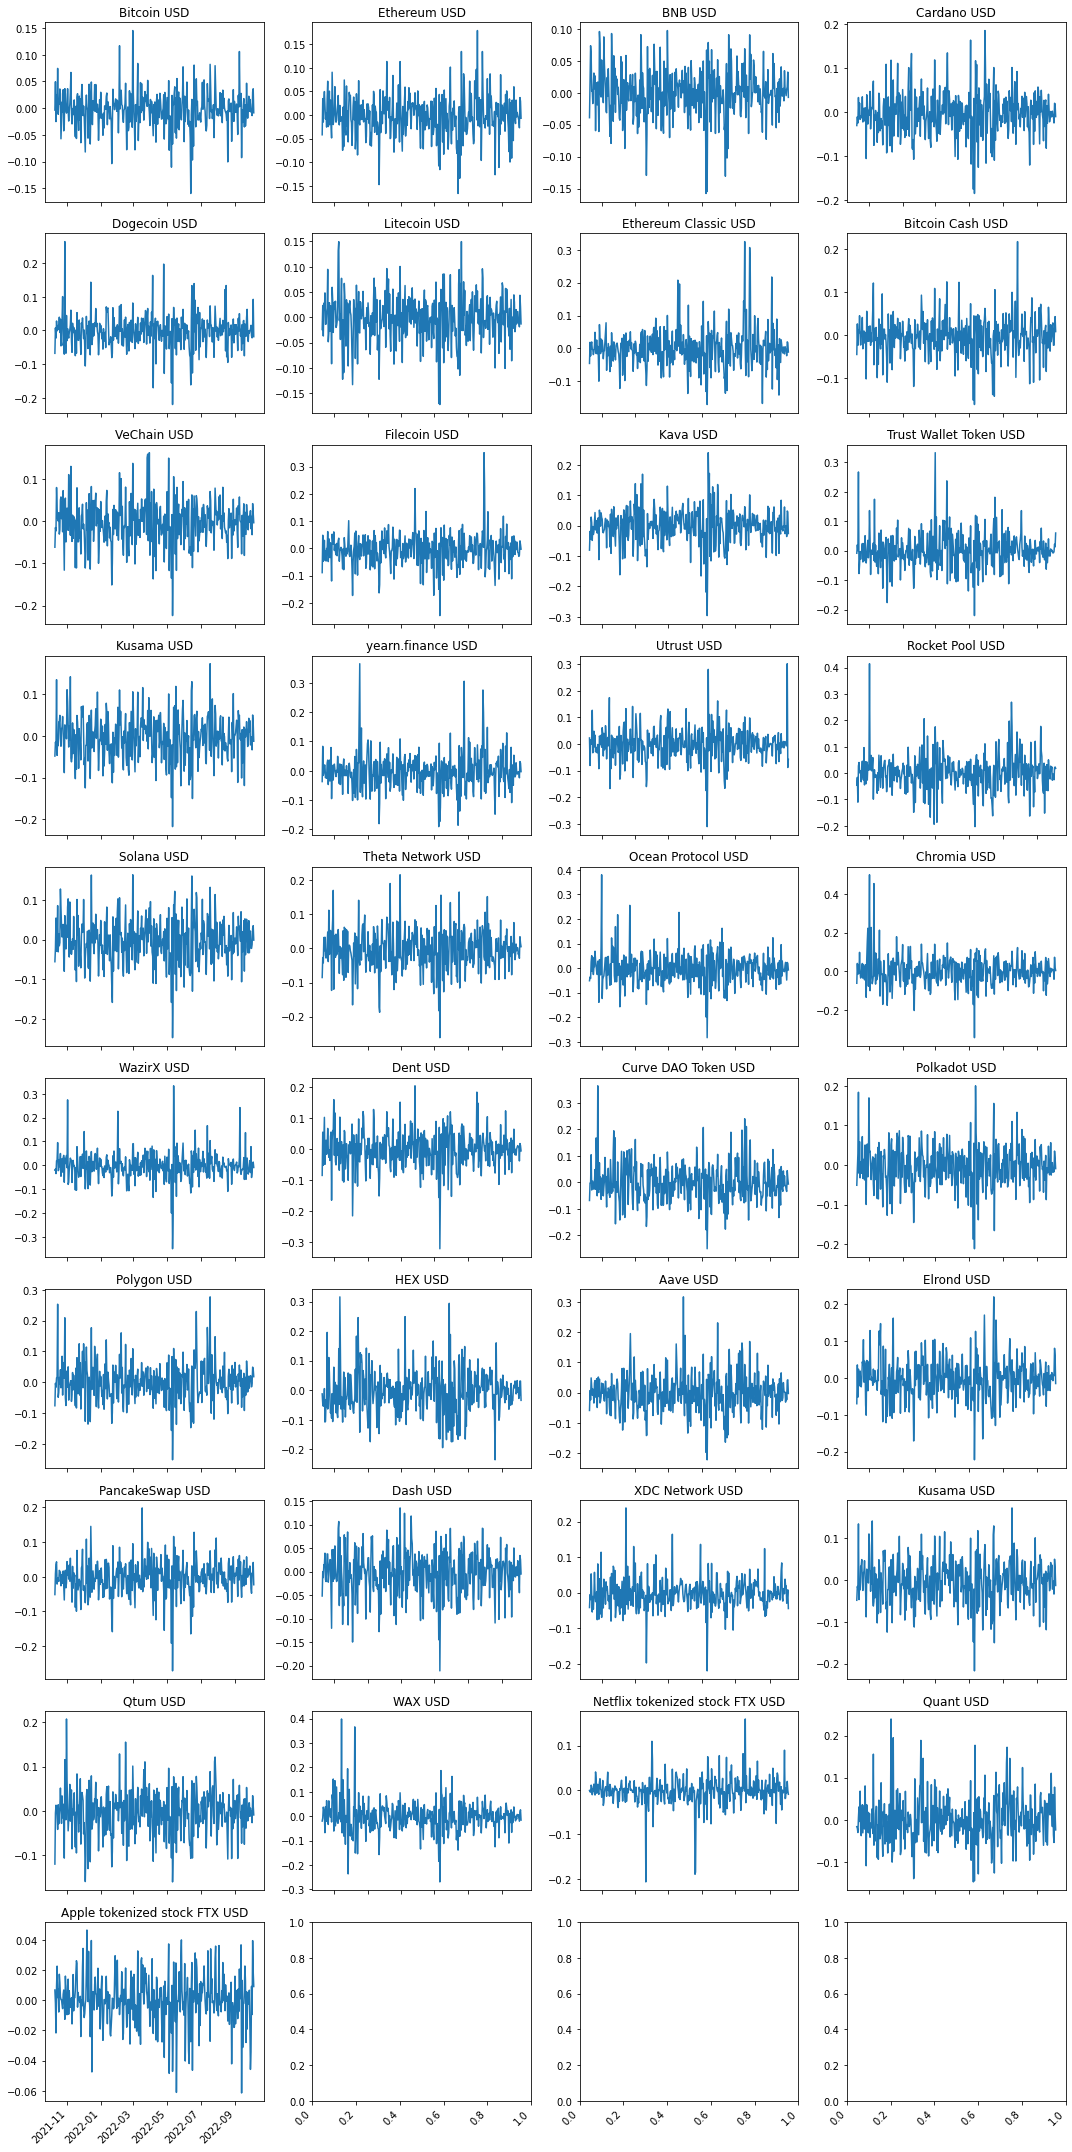

                          Cluster name: cluster_min_feature
                          Cluster number: 1


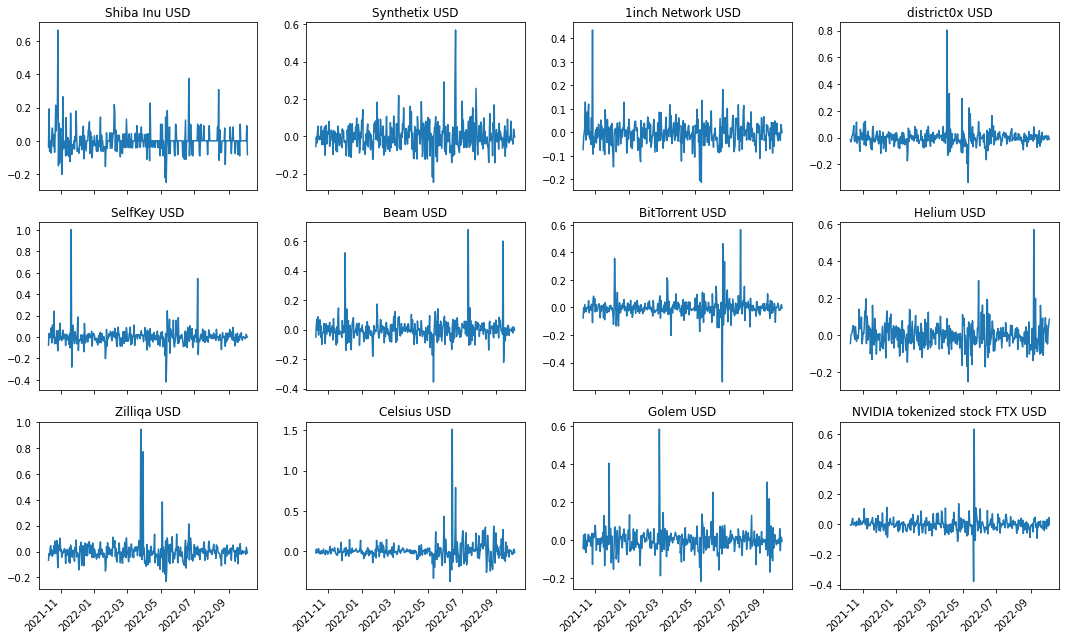

                          Cluster name: cluster_min_feature
                          Cluster number: 2


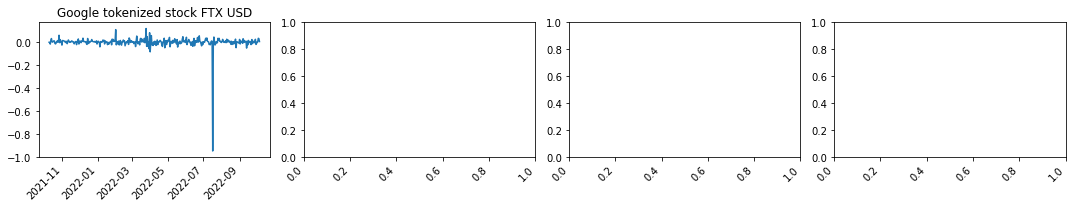

                          Cluster name: cluster_mid_feature
                          Cluster number: 0


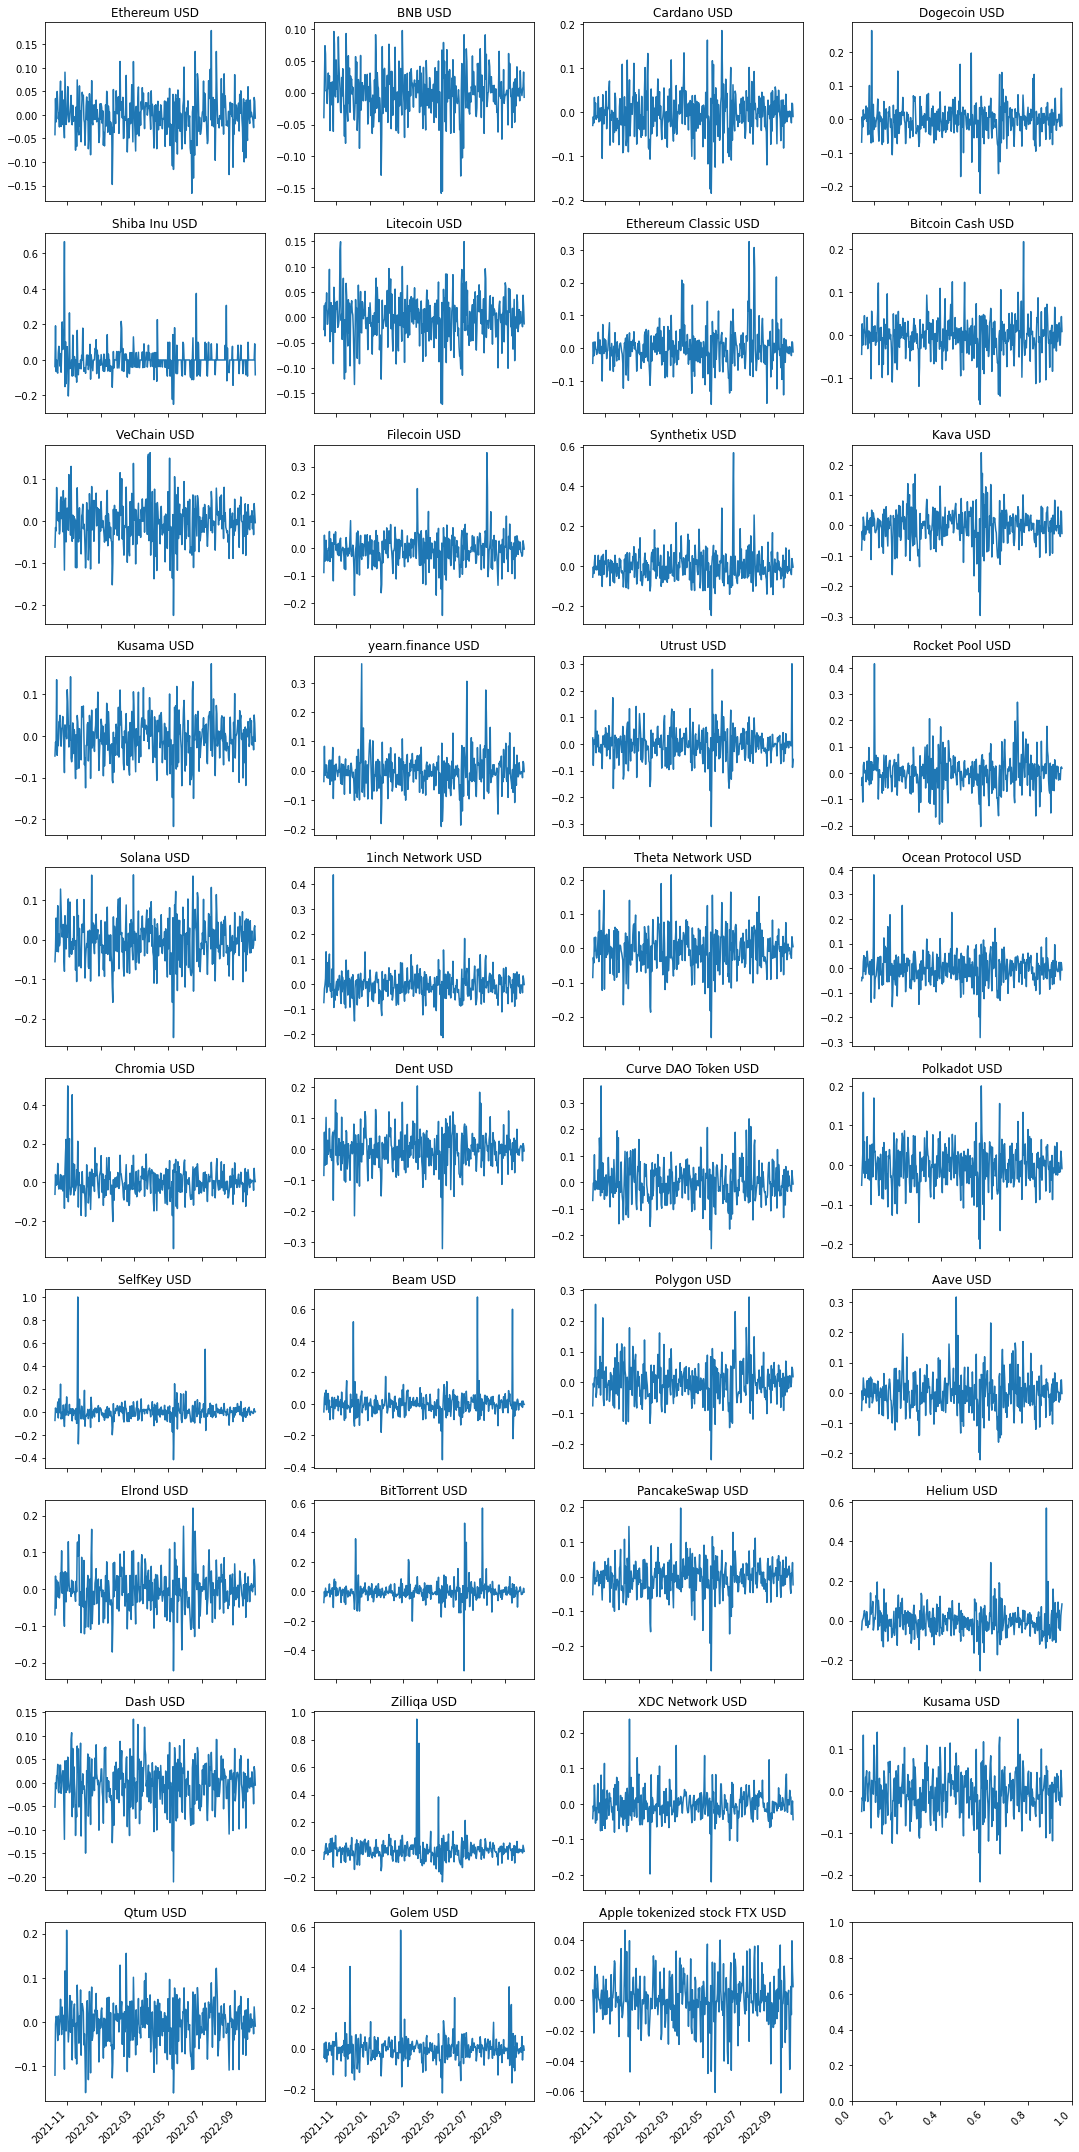

                          Cluster name: cluster_mid_feature
                          Cluster number: 1


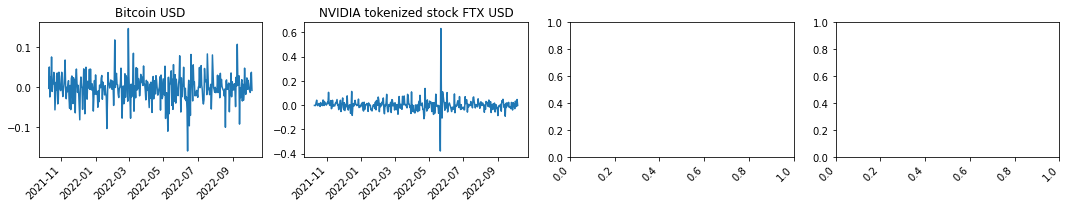

                          Cluster name: cluster_mid_feature
                          Cluster number: 2


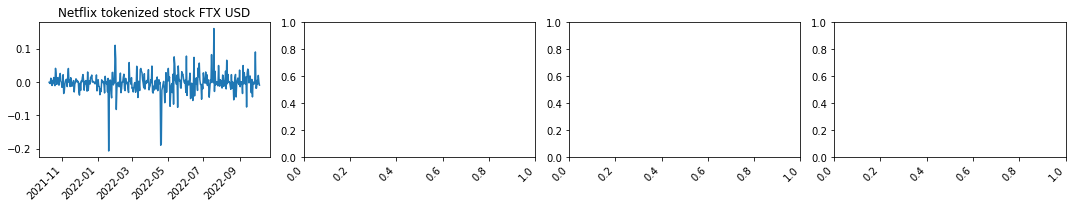

                          Cluster name: cluster_mid_feature
                          Cluster number: 3


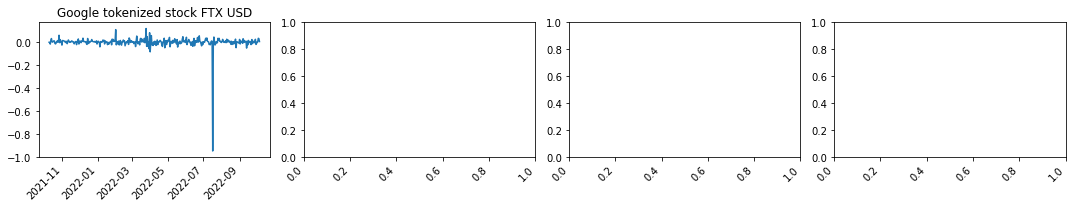

                          Cluster name: cluster_mid_feature
                          Cluster number: 4


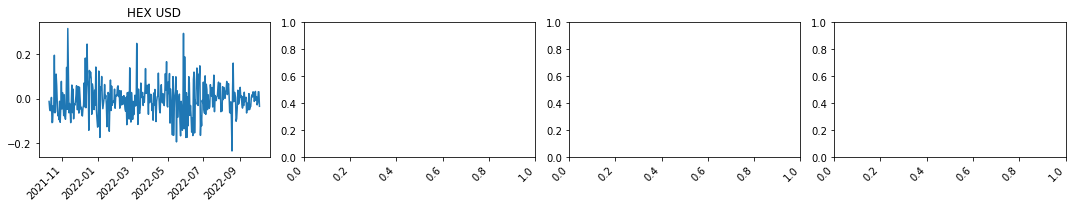

                          Cluster name: cluster_mid_feature
                          Cluster number: 5


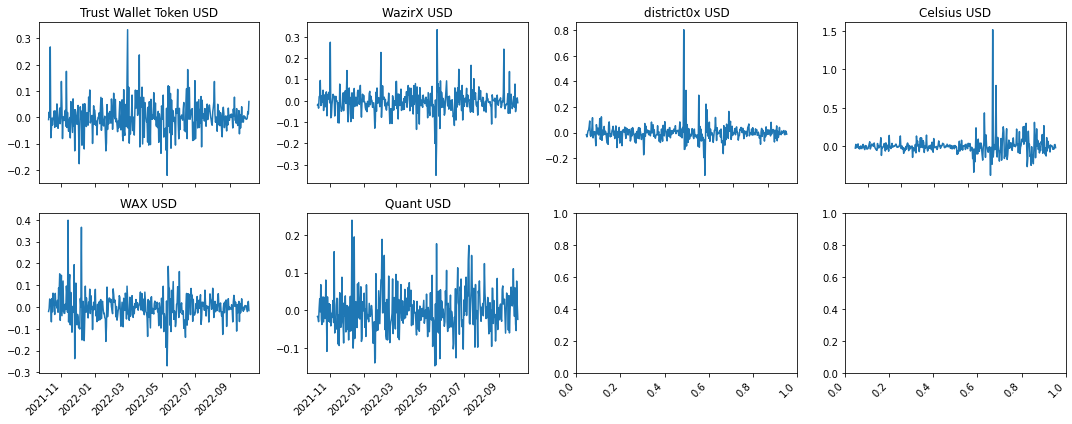

                          Cluster name: cluster_broad_feature
                          Cluster number: 0


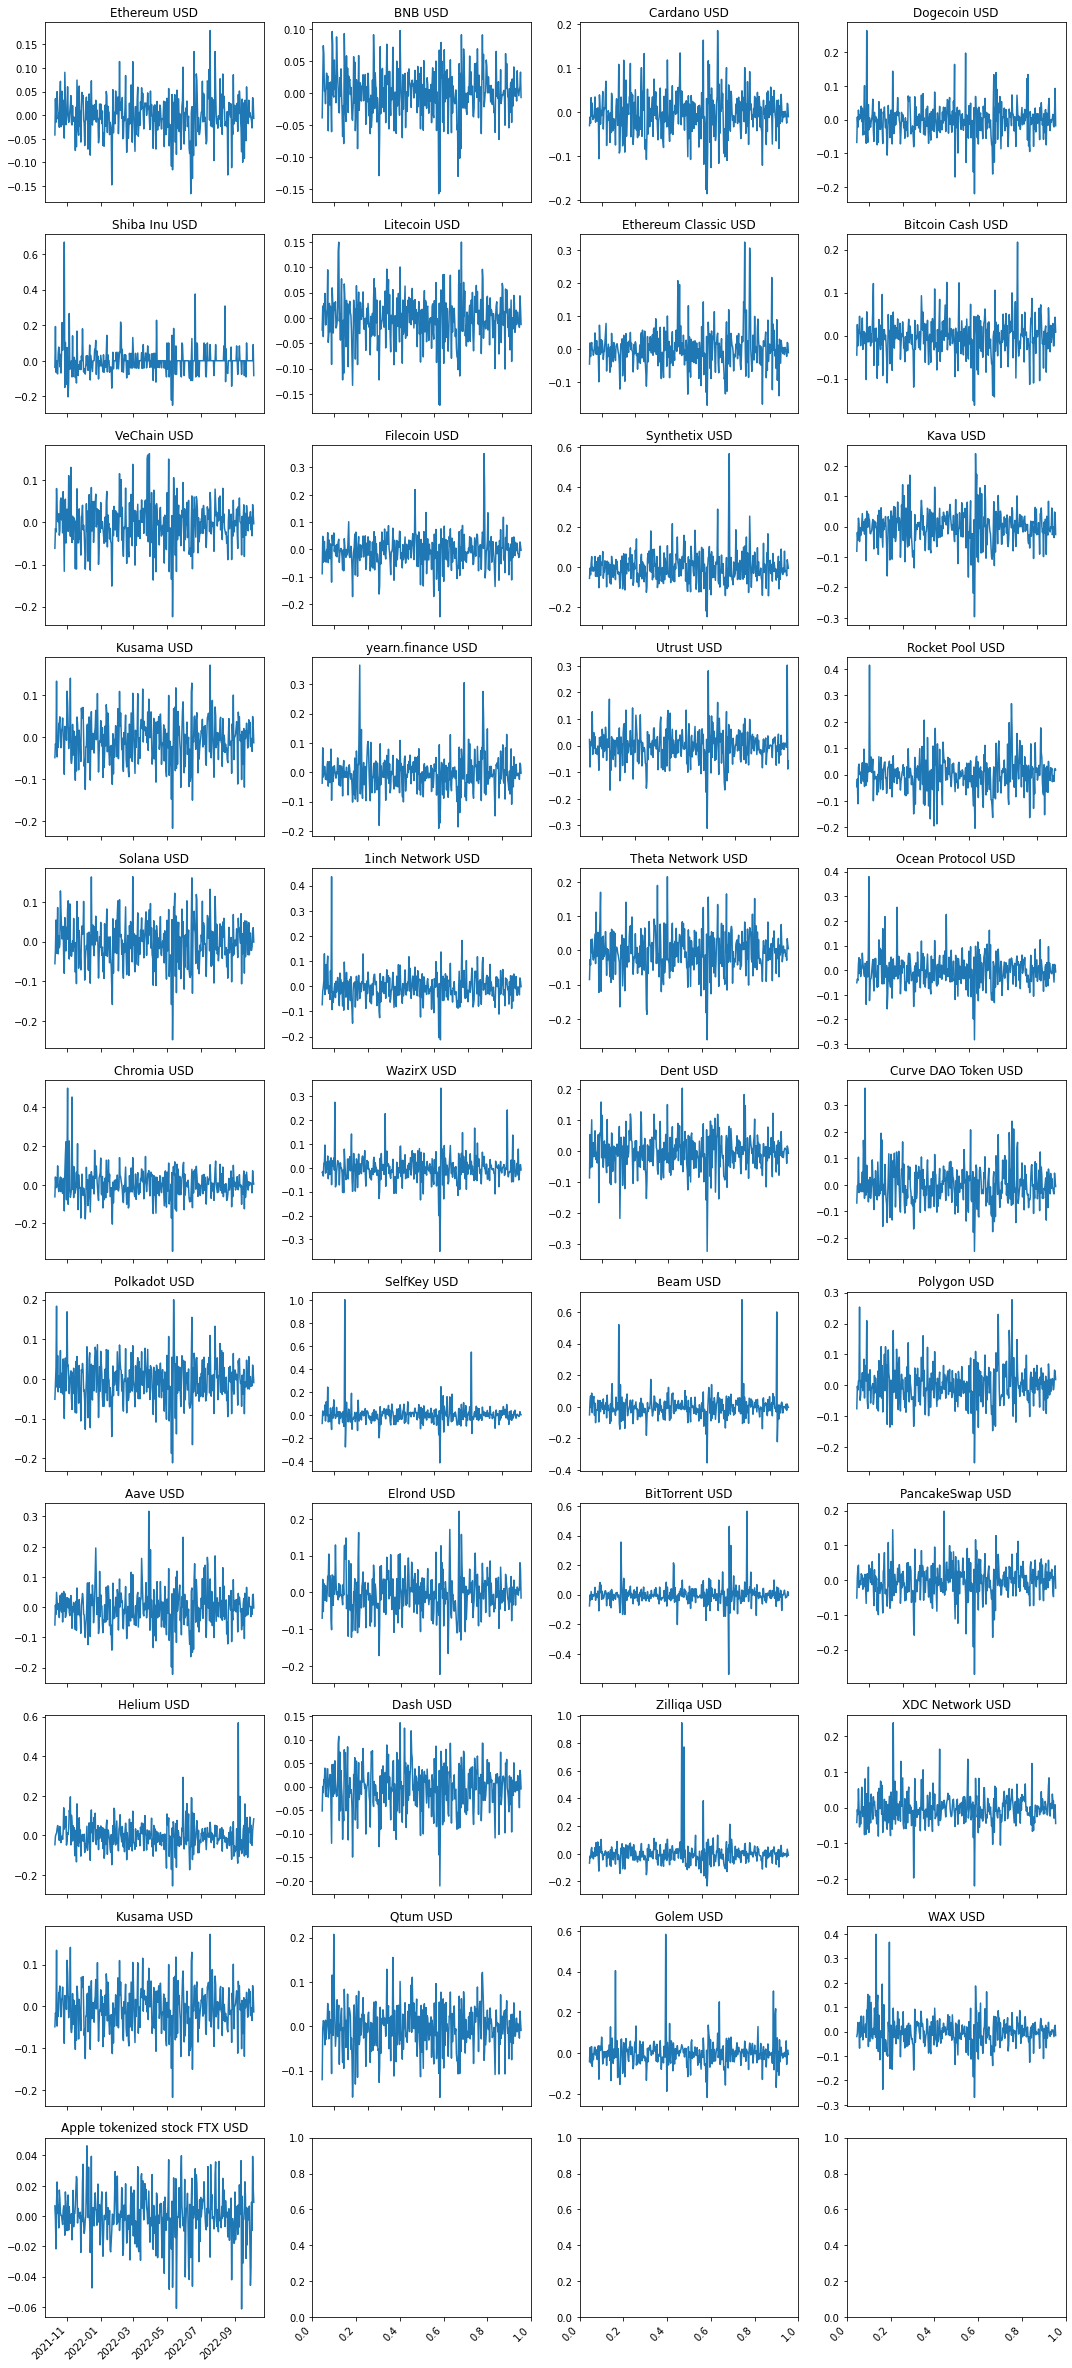

                          Cluster name: cluster_broad_feature
                          Cluster number: 1


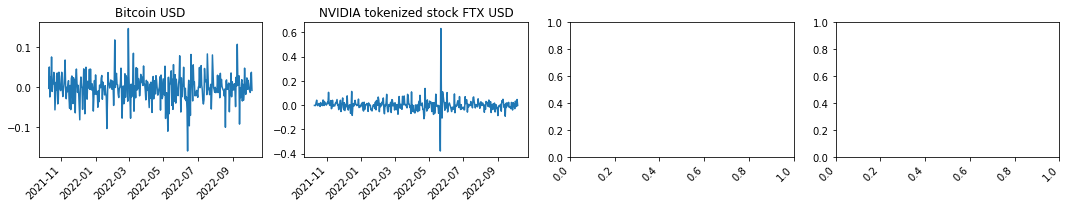

                          Cluster name: cluster_broad_feature
                          Cluster number: 2


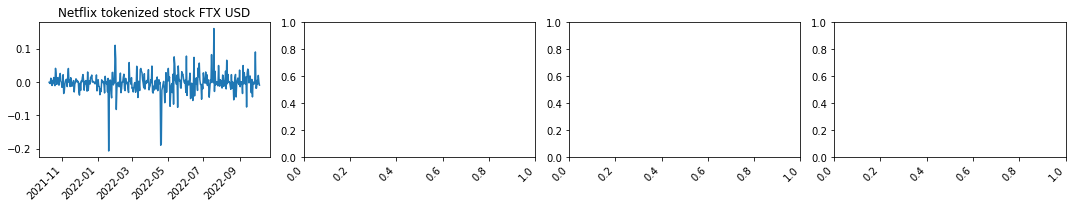

                          Cluster name: cluster_broad_feature
                          Cluster number: 3


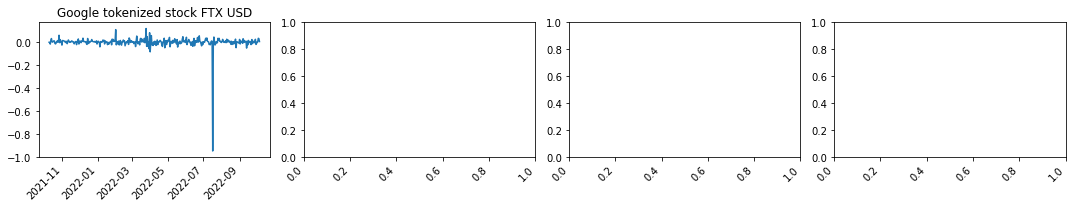

                          Cluster name: cluster_broad_feature
                          Cluster number: 4


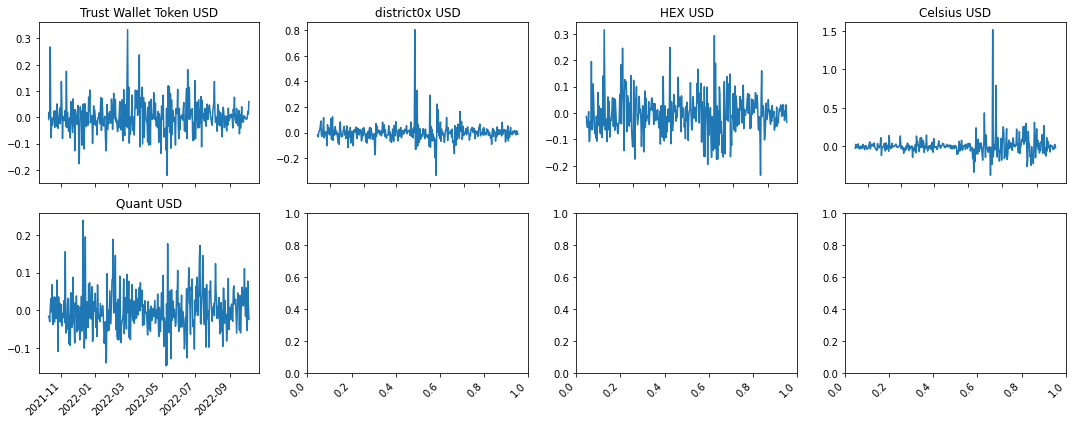

In [45]:
figsize = (10,10)
i=0
for dframe, name in zip([full_ticker_df_1, full_ticker_df_2, full_ticker_df_3], ['cluster_min_feature','cluster_mid_feature', 'cluster_broad_feature']):
    
    for cluster in range(n_clusters[i]):
        print(f"                          Cluster name: {name}")
        print("=================================================================================")
        print(f"                          Cluster number: {cluster}")
        print("=================================================================================")
        plot_cluster_tickers(dframe[dframe[name]==cluster])
    print("=================================================================================")
    print("=================================================================================")
    print("=================================================================================")
    i=i+1


# Visualisation using Tsfel as an example (apply another feature extractor and see how it works).

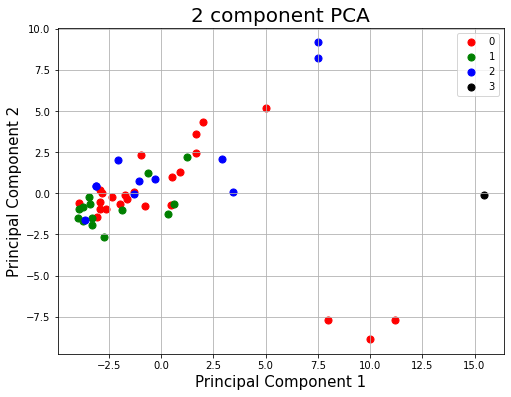

In [46]:
kmeanModel_tsfel = TimeSeriesKMeans(n_clusters=4)
kmeanModel_tsfel.fit(tickers_scaled)
clusters_tsfel = kmeanModel_tsfel.predict(tickers_scaled)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tickers_scaled)
principalDf = pd.DataFrame(data = X_pca , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame(clusters_tsfel, columns=['Cluster'])], axis = 1)
finalDf.head(3)
def plot_pca(finalDf):
    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [0, 1, 2, 3]
    colors = ['r', 'g', 'b', 'k']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['Cluster'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                  , finalDf.loc[indicesToKeep, 'principal component 2']
                  , c = color
                  , s = 50)
    ax.legend(targets)
    ax.grid()
plot_pca(finalDf)

# Visualise the best kMeans result with the extraction_settings_Minimal feature extractor

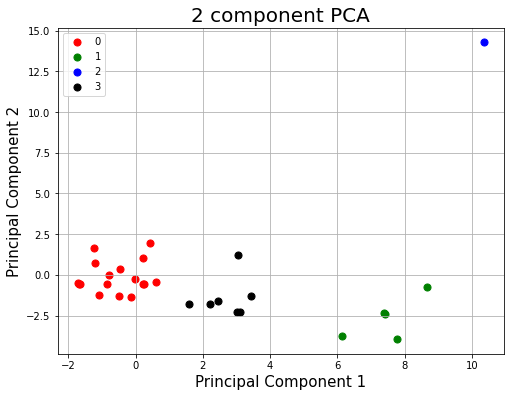

In [47]:
ts_kmeans.fit(X_Minimal)
clusters_ts_X_feature_Min = ts_kmeans.predict(X_Minimal)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_Minimal)
principalDf = pd.DataFrame(data = X_pca , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame(clusters_ts_X_feature_Min, columns=['Cluster'])], axis = 1)
finalDf.head(3)
def plot_pca(finalDf):
    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [0, 1, 2, 3]
    colors = ['r', 'g', 'b', 'k']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['Cluster'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                  , finalDf.loc[indicesToKeep, 'principal component 2']
                  , c = color
                  , s = 50)
    ax.legend(targets)
    ax.grid()
plot_pca(finalDf)

# Conclusion:
1. The naked eye can see that the tsfresh extractor distinguishes clusters better than tsfell. 
2. It turned out that for the current set of indices (assets) it would be a better feature to minimise the set of metrics: a more detailed and accurate distribution into 4 clusters was obtained.